In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sayantikalaskar","key":"9c46cbc3dc0f3d53e9eef348359a288e"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone

Dataset URL: https://www.kaggle.com/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone
License(s): copyright-authors
100% 1.52G/1.52G [00:49<00:00, 36.9MB/s]
100% 1.52G/1.52G [00:49<00:00, 32.7MB/s]


In [5]:
!unzip ct-kidney-dataset-normal-cyst-tumor-and-stone.zip

Streaming output truncated to the last 5000 lines.
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4363).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4364).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4365).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4366).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4367).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4368).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4369).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-N

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D

In [7]:
batch_size = 32
img_height = 150
img_width = 150

In [8]:
data_dir='/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
train=tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(img_height,img_width),
                                                validation_split=0.1,
                                                subset='training',seed=123)
val=tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(img_height,img_width),
                                                validation_split=0.2,
                                                subset='validation',seed=123)

Found 12446 files belonging to 4 classes.
Using 11202 files for training.
Found 12446 files belonging to 4 classes.
Using 2489 files for validation.


In [9]:
label_to_class_name = dict(zip(range(len(train.class_names)), train.class_names))
label_to_class_name

{0: 'Cyst', 1: 'Normal', 2: 'Stone', 3: 'Tumor'}

In [10]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32,)


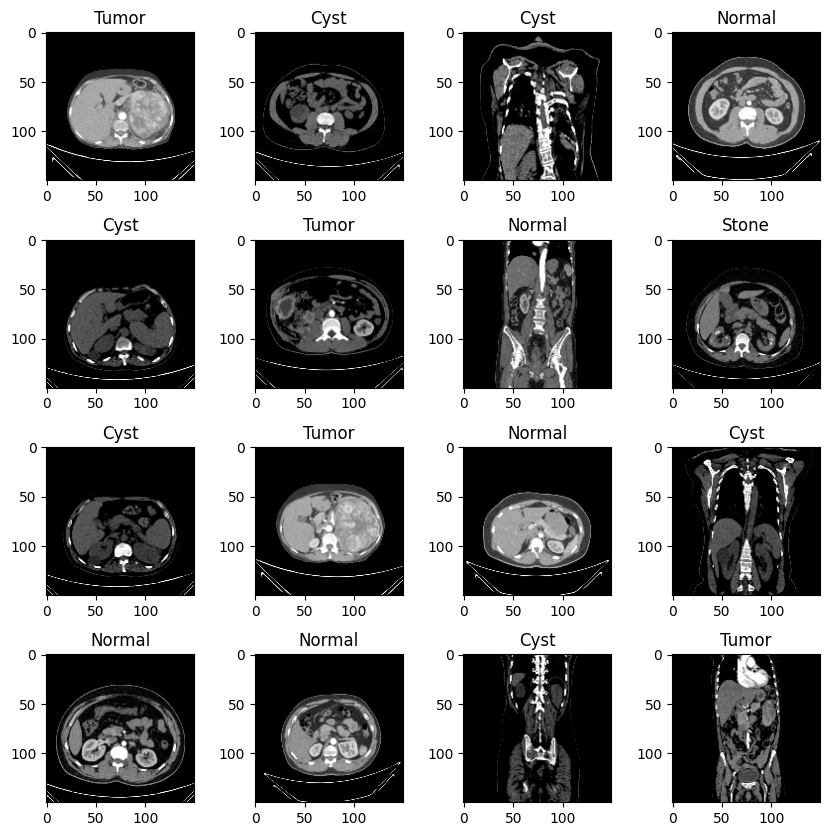

In [11]:
data_iterator = train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        index = i * 4 + j
        ax[i, j].imshow(batch[0][index].astype(int))
        ax[i, j].set_title(label_to_class_name[batch[1][index]])
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

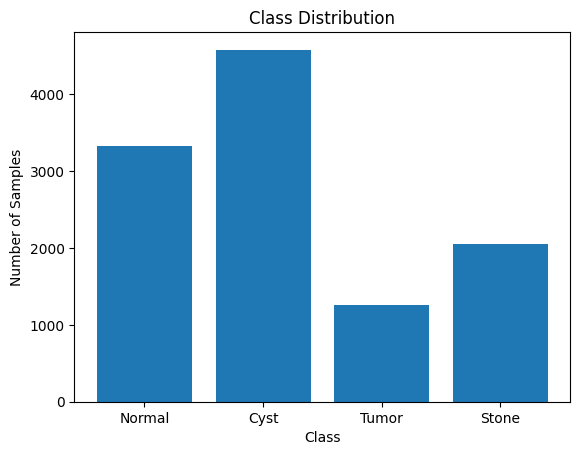

In [15]:
# Manually specify class names based on your dataset structure or labels
class_names = ['Normal', 'Cyst', 'Tumor', 'Stone']

# Initialize counts for each class
num_classes = len(class_names)
counts = np.zeros(num_classes, dtype=int)

# Count samples per class
for images, labels in train:
    label_indices = labels.numpy()
    for label_index in label_indices:
        counts[label_index] += 1

# Plotting the class distribution
plt.bar(class_names, counts)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()

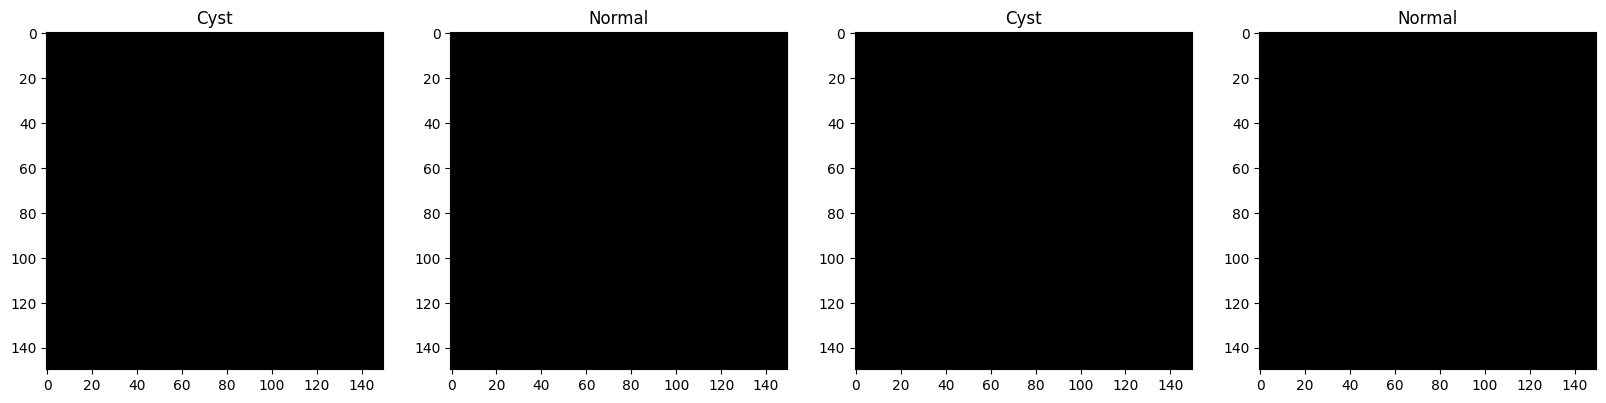

In [16]:
# Display sample images
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
for i, (images, labels) in enumerate(train.take(1)):
    for j in range(4):
        ax[j].imshow(images[j].numpy().astype("uint8"))
        ax[j].set_title(label_to_class_name[labels[j].numpy()])
plt.show()

In [17]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

In [18]:
# Normalize images
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_train = train.map(lambda x, y: (normalization_layer(x), y))
normalized_val = val.map(lambda x, y: (normalization_layer(x), y))

In [20]:
# Initialize variables to accumulate mean and std
mean = 0.0
std = 0.0
num_samples = 0

# Iterate through the dataset to compute mean and std
for images, labels in train:
    batch_samples = images.shape[0]  # number of images in the batch
    images = images.numpy()  # convert images tensor to numpy array
    mean += np.mean(images, axis=(0, 1, 2)) * batch_samples
    std += np.std(images, axis=(0, 1, 2)) * batch_samples
    num_samples += batch_samples

# Calculate final mean and std
mean /= num_samples
std /= num_samples

print(f"Mean pixel value across dataset: {mean}")
print(f"Std deviation of pixel values across dataset: {std}")

Mean pixel value across dataset: [0.14376424 0.14376424 0.14376424]
Std deviation of pixel values across dataset: [0.23898172 0.23898172 0.23898172]


In [12]:
train=train.map(lambda x,y:(x/255,y))
val=val.map(lambda x,y:(x/255,y))

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(4, activation=tf.nn.softmax)
])
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
epochs=15
history = model.fit(
  train,
  validation_data=val,
  epochs=epochs
)

Epoch 1/15
351/351 [==============================] - 54s 139ms/step - loss: 0.1439 - accuracy: 0.9525 - val_loss: 7.8940e-04 - val_accuracy: 1.0000
Epoch 2/15
351/351 [==============================] - 6s 17ms/step - loss: 2.9228e-04 - accuracy: 1.0000 - val_loss: 1.0936e-04 - val_accuracy: 1.0000
Epoch 3/15
351/351 [==============================] - 6s 18ms/step - loss: 7.4584e-05 - accuracy: 1.0000 - val_loss: 5.3699e-05 - val_accuracy: 1.0000
Epoch 4/15
351/351 [==============================] - 6s 18ms/step - loss: 3.8802e-05 - accuracy: 1.0000 - val_loss: 3.2100e-05 - val_accuracy: 1.0000
Epoch 5/15
351/351 [==============================] - 6s 18ms/step - loss: 2.3744e-05 - accuracy: 1.0000 - val_loss: 2.0858e-05 - val_accuracy: 1.0000
Epoch 6/15
351/351 [==============================] - 7s 19ms/step - loss: 1.5798e-05 - accuracy: 1.0000 - val_loss: 1.4471e-05 - val_accuracy: 1.0000
Epoch 7/15
351/351 [==============================] - 6s 17ms/step - loss: 1.1088e-05 - accuracy

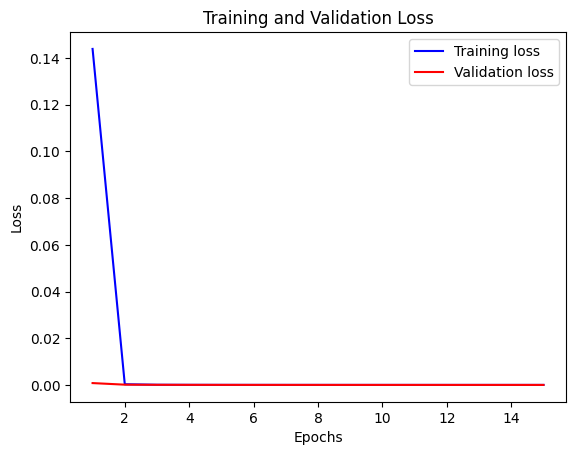

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

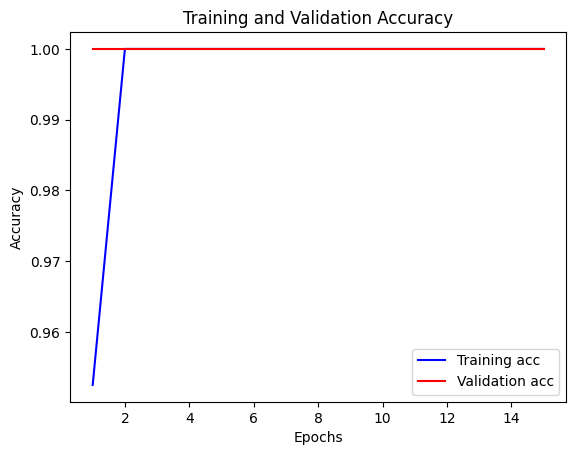

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

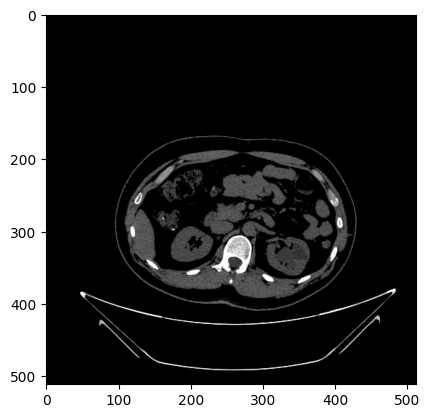

1/1 [==============================] - 0s 242ms/step


'Cyst'

In [25]:
img = cv2.imread('/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (1004).jpg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (150,150))
yhat = model.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
label_to_class_name[max_index]

In [26]:
VGG_model = Sequential()

pretrained_model= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(150,150,3),
                   pooling='max',classes=4,
                   weights='imagenet')


VGG_model.add(pretrained_model)
VGG_model.add(Flatten())
VGG_model.add(Dense(512, activation='relu'))
VGG_model.add(BatchNormalization())  # Batch Normalization layer
VGG_model.add(Dropout(0.5))

VGG_model.add(Dense(4, activation='softmax'))
pretrained_model.trainable=False

58889256/58889256 [==============================] - 2s 0us/step


In [27]:
VGG_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
VGG_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 2052      
                                                      

In [28]:
epochs=15
history = VGG_model.fit(
  train,
  validation_data=val,
  epochs=epochs
)

Epoch 1/15
351/351 [==============================] - 39s 89ms/step - loss: 0.5003 - accuracy: 0.8140 - val_loss: 0.2908 - val_accuracy: 0.8895
Epoch 2/15
351/351 [==============================] - 28s 79ms/step - loss: 0.2303 - accuracy: 0.9189 - val_loss: 0.1864 - val_accuracy: 0.9341
Epoch 3/15
351/351 [==============================] - 28s 79ms/step - loss: 0.1691 - accuracy: 0.9431 - val_loss: 0.0959 - val_accuracy: 0.9707
Epoch 4/15
351/351 [==============================] - 27s 78ms/step - loss: 0.1477 - accuracy: 0.9485 - val_loss: 0.0857 - val_accuracy: 0.9727
Epoch 5/15
351/351 [==============================] - 27s 78ms/step - loss: 0.1301 - accuracy: 0.9530 - val_loss: 0.0675 - val_accuracy: 0.9787
Epoch 6/15
351/351 [==============================] - 28s 79ms/step - loss: 0.1138 - accuracy: 0.9601 - val_loss: 0.1009 - val_accuracy: 0.9626
Epoch 7/15
351/351 [==============================] - 28s 80ms/step - loss: 0.1059 - accuracy: 0.9612 - val_loss: 0.0924 - val_accuracy:

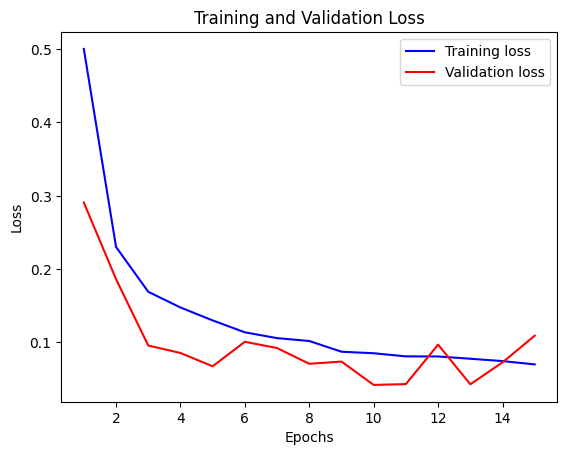

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

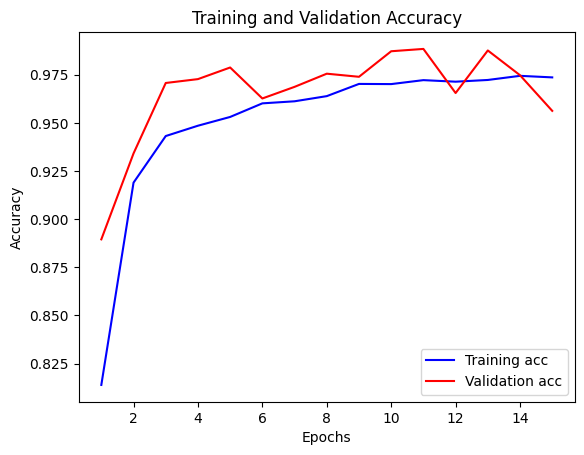

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

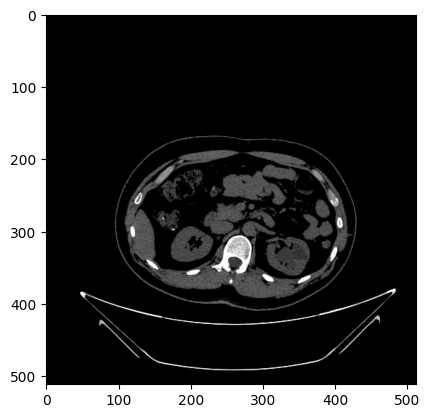

1/1 [==============================] - 1s 1s/step


'Cyst'

In [31]:
img = cv2.imread('/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (1004).jpg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (150,150))
yhat = VGG_model.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
label_to_class_name[max_index]

In [32]:
mobile_net = Sequential()

pretrained_model= tf.keras.applications.MobileNetV2(include_top=False,
                   input_shape=(150,150,3),
                   pooling='max',classes=4,
                   weights='imagenet')


mobile_net.add(pretrained_model)
mobile_net.add(Flatten())
mobile_net.add(Dense(512, activation='relu'))
mobile_net.add(BatchNormalization())  # Batch Normalization layer
mobile_net.add(Dropout(0.5))

mobile_net.add(Dense(4, activation='softmax'))
pretrained_model.trainable=False

9406464/9406464 [==============================] - 1s 0us/step


In [33]:
mobile_net.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
mobile_net.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               655872    
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                

In [34]:
epochs=15
history = mobile_net.fit(
  train,
  validation_data=val,
  epochs=epochs
)

Epoch 1/15
351/351 [==============================] - 16s 33ms/step - loss: 0.3971 - accuracy: 0.8631 - val_loss: 0.2476 - val_accuracy: 0.9128
Epoch 2/15
351/351 [==============================] - 10s 27ms/step - loss: 0.1355 - accuracy: 0.9546 - val_loss: 0.0708 - val_accuracy: 0.9823
Epoch 3/15
351/351 [==============================] - 11s 30ms/step - loss: 0.0829 - accuracy: 0.9721 - val_loss: 0.0650 - val_accuracy: 0.9787
Epoch 4/15
351/351 [==============================] - 9s 27ms/step - loss: 0.0576 - accuracy: 0.9819 - val_loss: 0.0335 - val_accuracy: 0.9924
Epoch 5/15
351/351 [==============================] - 9s 26ms/step - loss: 0.0667 - accuracy: 0.9775 - val_loss: 0.0560 - val_accuracy: 0.9839
Epoch 6/15
351/351 [==============================] - 10s 27ms/step - loss: 0.0513 - accuracy: 0.9845 - val_loss: 0.0216 - val_accuracy: 0.9936
Epoch 7/15
351/351 [==============================] - 9s 27ms/step - loss: 0.0364 - accuracy: 0.9891 - val_loss: 0.0369 - val_accuracy: 0.

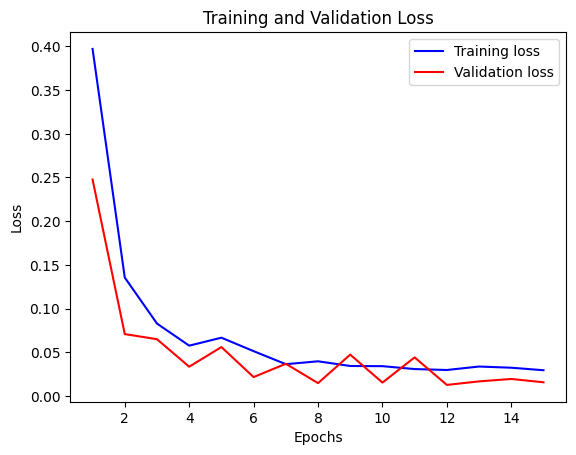

In [35]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

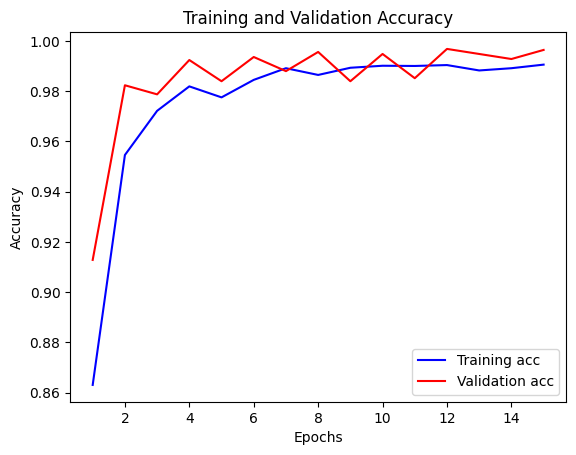

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

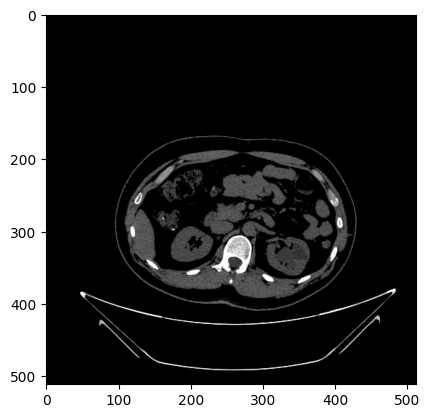

1/1 [==============================] - 1s 1s/step


'Cyst'

In [37]:
img = cv2.imread('/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (1004).jpg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (150,150))
yhat = mobile_net.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
label_to_class_name[max_index]

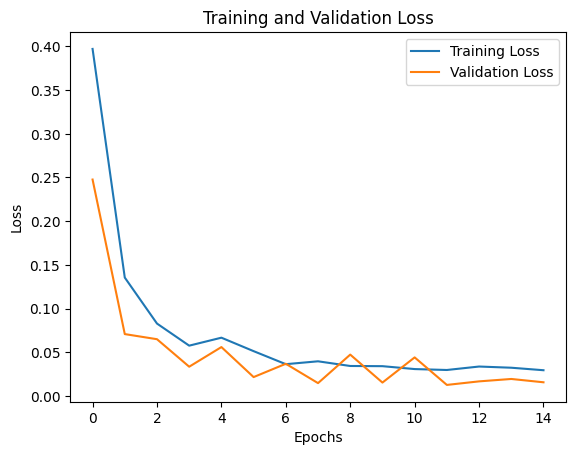

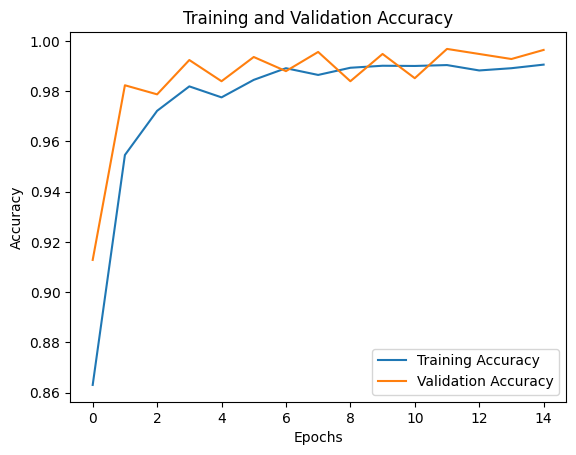

In [38]:
# Plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [40]:
# Store class names for reporting
class_names = list(label_to_class_name.values())

# Function to predict classes for the validation set
def predict_classes(model, val_dataset):
    y_pred = []
    y_true = []

    for images, labels in val_dataset:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(labels.numpy())

    return np.array(y_true), np.array(y_pred)

# Get true and predicted classes
y_true, y_pred = predict_classes(model, val)
# or replace `model` with `VGG_model` or `mobile_net` to evaluate other models

# Calculate classification metrics
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

1/1 [==============================] - 0s 21ms/step
              precision    recall  f1-score   support

        Cyst       1.00      1.00      1.00       737
      Normal       1.00      1.00      1.00      1001
       Stone       1.00      1.00      1.00       280
       Tumor       1.00      1.00      1.00       471

    accuracy                           1.00      2489
   macro avg       1.00      1.00      1.00      2489
weighted avg       1.00      1.00      1.00      2489



1/1 [==============================] - 0s 25ms/step


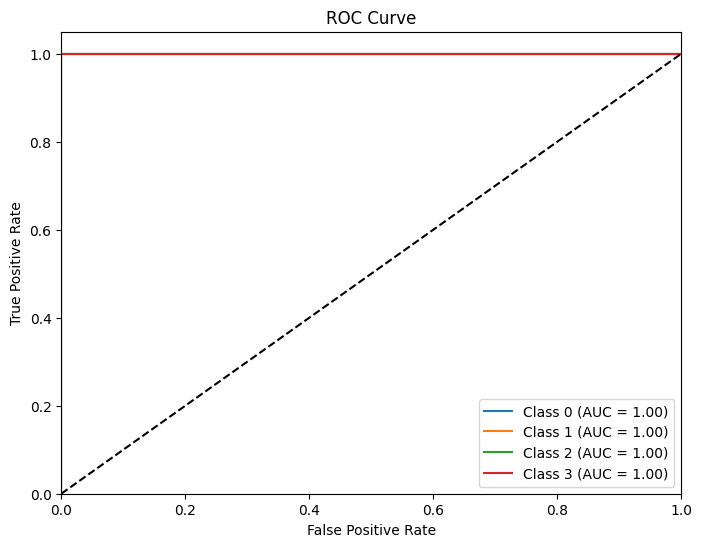

In [41]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp

# Function to calculate ROC AUC for each class
def calculate_roc_auc(model, val_dataset):
    y_true = []
    y_score = []

    for images, labels in val_dataset:
        predictions = model.predict(images)
        y_true.extend(label_binarize(labels.numpy(), classes=np.arange(4)))
        y_score.extend(predictions)

    y_true = np.array(y_true)
    y_score = np.array(y_score)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):  # 4 is the number of classes
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    return fpr, tpr, roc_auc

# Calculate ROC AUC for the model
fpr, tpr, roc_auc = calculate_roc_auc(model, val)

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [42]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Compute precision for each class
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
print('Precision:')
print(precision)

Confusion Matrix:
[[ 737    0    0    0]
 [   0 1001    0    0]
 [   0    0  280    0]
 [   0    0    0  471]]
Precision:
[1. 1. 1. 1.]
